### Frame encode and decode impl

**structure of one frame**

| packet | field        | size     | type   | description                                      |
| ------ | ------------ | -------- | ------ | ------------------------------------------------ |
| frame  | frame_id     | 8B       | uint64 | indicate which frame is it                       |
|        | frame_stamp  | 8B       | uint64 | xxx ms passed                                    |
|        | config       | 12B      | config | info needed by decode                            |
|        | deep_size    | 4B       | int32  | size of deepth data                              |
|        | rgb_size     | 4B       | int32  | size of rgb data                                 |
|        | payload      | adaptive | bytes  | payload data, size is not fixed                  |
| config | trigger_mode | 1B       | uint8  | 0:STOP 1:AUTO 2:SINGLE                           |
|        | deep_mode    | 1B       | uint8  | 0:16bit 1:8bit                                   |
|        | deep_shift   | 1B       | uint8  | shift xxx from 16bit, just working for 8bit mode |
|        | ir_mode      | 1B       | uint8  | 0:16bit 1:8bit                                   |
|        | status_mode  | 1B       | uint8  | 0:16bit 1:2bit 2:8bit 3:1bit                     |
|        | status_mask  | 1B       | uint8  | just working for 1bit mode 1:1 2:2 4:3           |
|        | rgb_mode     | 1B       | uint8  | 0:YUV 1:JPG 2:NULL                               |
|        | rgb_res      | 1B       | uint8  | 0:800\*600 1:1600\*1200                            |
|        | expose_time  | 4B       | int32  | expose time of this tof, 0 means AE(auto expose) |

In [1]:
import struct
import numpy as np
import cv2


def frame_config_decode(frame_config):
    '''
        @frame_config bytes

        @return fields, tuple (trigger_mode, deep_mode, deep_shift, ir_mode, status_mode, status_mask, rgb_mode, rgb_res, expose_time)
    '''
    return struct.unpack("<BBBBBBBBi", frame_config)


def frame_config_encode(trigger_mode=1, deep_mode=1, deep_shift=255, ir_mode=1, status_mode=2, status_mask=7, rgb_mode=1, rgb_res=0, expose_time=0):
    '''
        @trigger_mode, deep_mode, deep_shift, ir_mode, status_mode, status_mask, rgb_mode, rgb_res, expose_time

        @return frame_config bytes
    '''
    return struct.pack("<BBBBBBBBi",
                       trigger_mode, deep_mode, deep_shift, ir_mode, status_mode, status_mask, rgb_mode, rgb_res, expose_time)


def frame_payload_decode(frame_data: bytes, with_config: tuple):
    '''
        @frame_data, bytes

        @with_config, tuple (trigger_mode, deep_mode, deep_shift, ir_mode, status_mode, status_mask, rgb_mode, rgb_res, expose_time)

        @return imgs, tuple (deepth_img, ir_img, status_img, rgb_img)
    '''
    deep_data_size, rgb_data_size = struct.unpack("<ii", frame_data[:8])
    frame_payload = frame_data[8:]
    # 0:16bit 1:8bit, resolution: 320*240
    deepth_size = (320*240*2) >> with_config[1]
    deepth_img = struct.unpack("<%us" % deepth_size, frame_payload[:deepth_size])[
        0] if 0 != deepth_size else None
    frame_payload = frame_payload[deepth_size:]

    # 0:16bit 1:8bit, resolution: 320*240
    ir_size = (320*240*2) >> with_config[3]
    ir_img = struct.unpack("<%us" % ir_size, frame_payload[:ir_size])[
        0] if 0 != ir_size else None
    frame_payload = frame_payload[ir_size:]

    status_size = (320*240//8) * (16 if 0 == with_config[4] else
                                  2 if 1 == with_config[4] else 8 if 2 == with_config[4] else 1)
    status_img = struct.unpack("<%us" % status_size, frame_payload[:status_size])[
        0] if 0 != status_size else None
    frame_payload = frame_payload[status_size:]

    assert(deep_data_size == deepth_size+ir_size+status_size)

    rgb_size = len(frame_payload)
    assert(rgb_data_size == rgb_size)
    rgb_img = struct.unpack("<%us" % rgb_size, frame_payload[:rgb_size])[
        0] if 0 != rgb_size else None

    if (not rgb_img is None):
        if (1 == with_config[6]):
            jpeg = cv2.imdecode(np.frombuffer(
                rgb_img, 'uint8', rgb_size), cv2.IMREAD_COLOR)
            if not jpeg is None:
                rgb = cv2.cvtColor(jpeg, cv2.COLOR_BGR2RGB)
                rgb_img = rgb.tobytes()
            else:
                rgb_img = None
        # elif 0 == with_config[6]:
        #     yuv = np.frombuffer(rgb_img, 'uint8', rgb_size)
        #     print(len(yuv))
        #     if not yuv is None:
        #         rgb = cv2.cvtColor(yuv, cv2.COLOR_YUV420P2RGB)
        #         rgb_img = rgb.tobytes()
        #     else:
        #         rgb_img = None

    return (deepth_img, ir_img, status_img, rgb_img)


### Frame capture from network impl

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import requests

HOST = '192.168.233.1'
PORT = 80

def post_encode_config(config=frame_config_encode(),host=HOST, port=PORT):
    r = requests.post('http://{}:{}/set_cfg'.format(host, port), config)
    if(r.status_code == requests.codes.ok):
        return True
    return False

def post_CameraParmsBytes(cameraParms:bytes,host=HOST, port=PORT):
    r = requests.post('http://{}:{}/calibration'.format(host, port), cameraParms)
    if(r.status_code == requests.codes.ok):
        print("ok")

def get_frame_from_http(host=HOST, port=PORT):
    r = requests.get('http://{}:{}/getdeep'.format(host, port))
    if(r.status_code == requests.codes.ok):
        print('Get deep image')
        deepimg = r.content
        print('Length={}'.format(len(deepimg)))
        (frameid, stamp_msec) = struct.unpack('<QQ', deepimg[0:8+8])
        print((frameid, stamp_msec/1000))
        return deepimg


### Example of how to show one frame

- network example(2D)
- local file example(2D, 3D)

#### show frame impl

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

def show_frame(frame_data: bytes):
    config = frame_config_decode(frame_data[16:16+12])
    frame_bytes = frame_payload_decode(frame_data[16+12:], config)

    depth = np.frombuffer(frame_bytes[0], 'uint16' if 0 == config[1] else 'uint8').reshape(
        240, 320) if frame_bytes[0] else None

    ir = np.frombuffer(frame_bytes[1], 'uint16' if 0 == config[3] else 'uint8').reshape(
        240, 320) if frame_bytes[1] else None

    status = np.frombuffer(frame_bytes[2], 'uint16' if 0 == config[4] else 'uint8').reshape(
        240, 320) if frame_bytes[2] else None

    rgb = np.frombuffer(frame_bytes[3], 'uint8').reshape(
        (480, 640, 3) if config[6] == 1 else (600, 800, 3)) if frame_bytes[3] else None

    figsize = (12, 12)
    fig = plt.figure(figsize=figsize)

    ax1 = fig.add_subplot(221)
    if not depth is None:
        ax1.imshow(depth)
        # np.save("fg1.npy", depth)
        # np.savetxt("depth.csv", (depth/4).astype('uint16'), delimiter="," )
    ax2 = fig.add_subplot(222)
    if not ir is None:
        ax2.imshow(ir)
    ax3 = fig.add_subplot(223)
    if not status is None:
        ax3.imshow(status)
    ax4 = fig.add_subplot(224)
    if not rgb is None:
        ax4.imshow(rgb)

    return depth


#### network example

Get deep image
Length=413745
(0, 405.882)


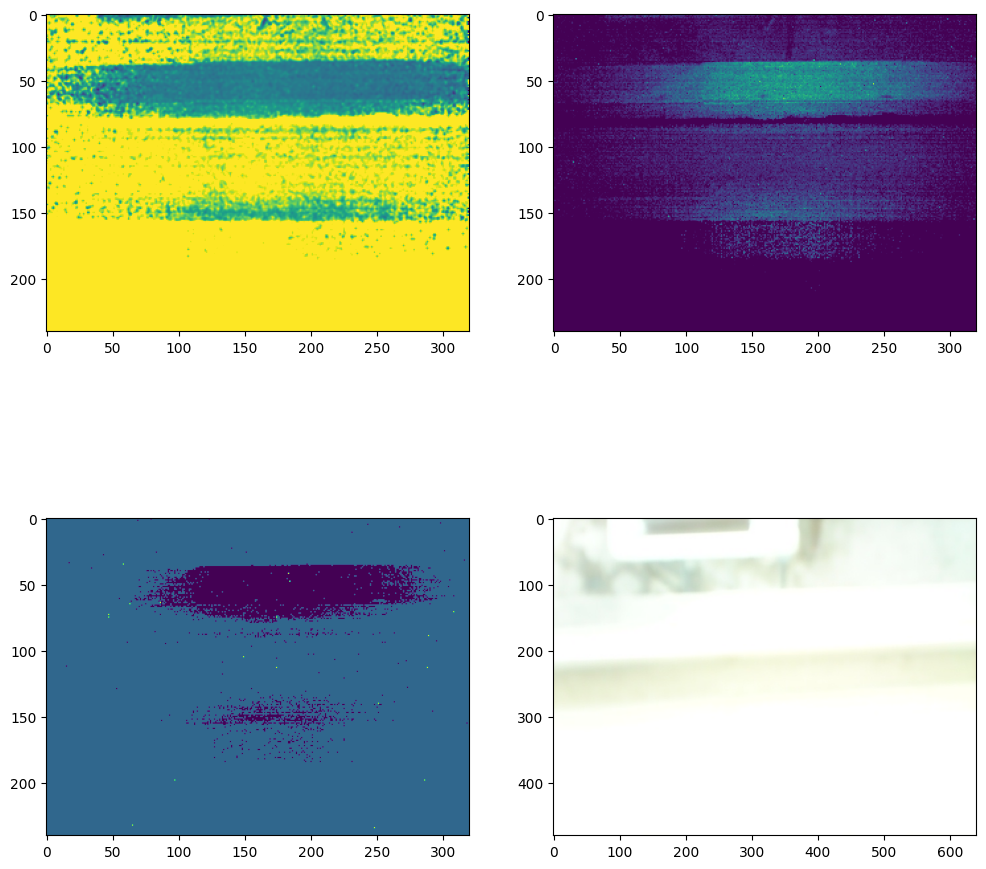

In [6]:
if post_encode_config(frame_config_encode(1,0,255,0,2,7,1,0,0)):
    p = get_frame_from_http()
    depth = show_frame(p)
    # with open("rgbd.raw", 'wb') as f:
    #     f.write(p)
    #     f.flush()

In [28]:
ir

NameError: name 'ir' is not defined

#### local file example

In [ ]:
with open("rgbd.raw", 'rb') as fp:
    file_data = fp.read()
    fp.close()
    show_frame(file_data)

#### local file example (3D)

need library open3d, your python version should be less than 3.9(included)

website: https://pypi.org/project/open3d/

install: pip install open3d

In [ ]:
import numpy as np
import open3d as o3d

points = o3d.io.read_point_cloud("rgbd.pcd")
o3d.visualization.draw_geometries([points])

## utils

In [17]:
with open("./sipeed/CameraParms.json", "rb") as f:
    post_CameraParmsBytes(f.read())

ok
